# Assignment 3: Histogram of Oriented Gradients (HOG)
## Read paper
Have a look at the section "Resources" in the KVV and read the original HOG work of Dalal and Triggs from 2005 and the good summary by Tomasi (I would read this first). Now you shouldn't have any problems with the implementation of the algorithm! 

## MIT-DB for people
Download the complete image data set here: http://pascal.inrialpes.fr/data/human/ 


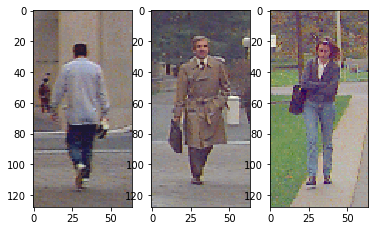

In [1]:
%matplotlib inline 
from skimage import io,color, transform
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import warnings
warnings.filterwarnings("ignore")

pers1 = io.imread('images/per00002.ppm')
pers2 = io.imread('images/per00007.ppm')
pers3 = io.imread('images/per00014.ppm')

fig = plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(pers1)
ax2.imshow(pers2)
ax3.imshow(pers3)


## Gradients and directions
First, implement the extraction of the gradient via convolution with the Sobel kernels. Translate the two result matrices into an image containing the gradient direction (one angle per pixel). Display this image for each of the three input images above. Like it fancy? Add transparency inversely proportional to the gradient magnitude (weak gradients are transparent). 

In [2]:
pers1.shape[:2]

(128, 64)

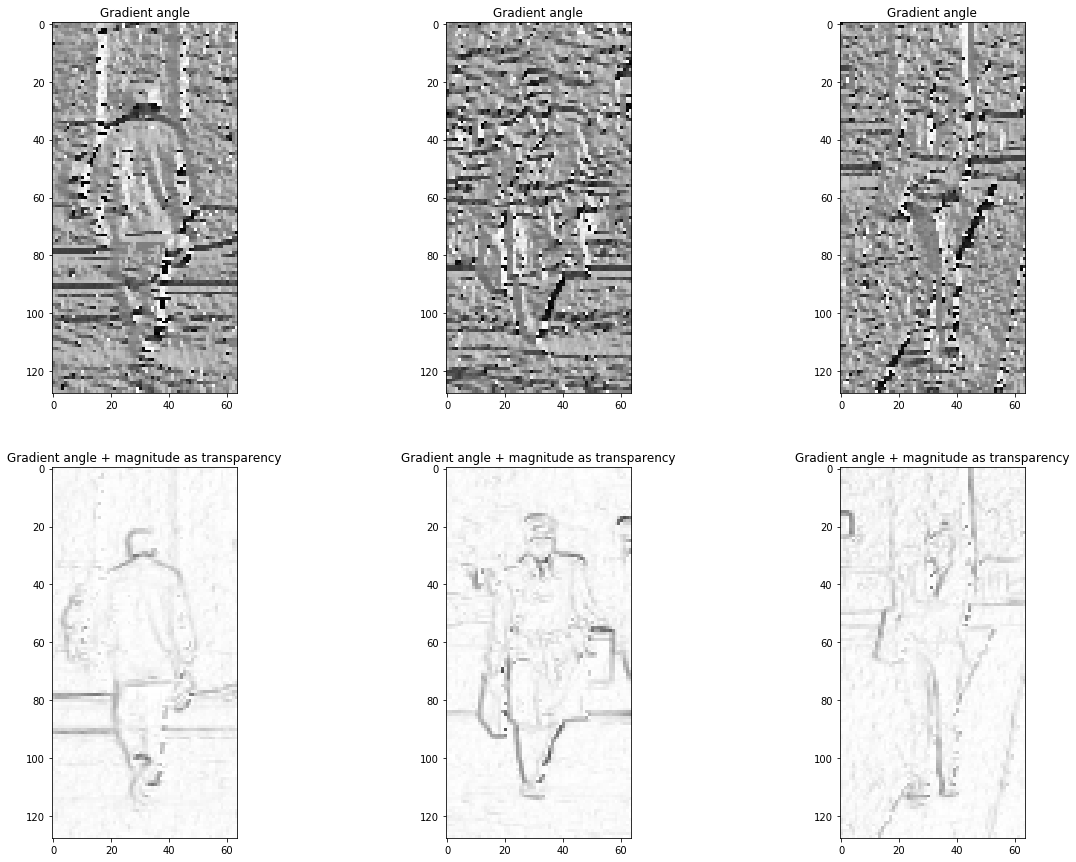

In [3]:
# dieser Code ist Teil eine Musterlösung, die von Adrian Defer zur Verfügung gestellt und von Tim renoviert wurde


def getGradientConv(image):
    Sx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])
    Sy = Sx.T
    
    # as suggested in the paper, we are going to compute
    # gradients in all 3 channels and take the maximum gradient
    # for each pixel
    
    # for each channel in both matrices, create an image_width x image_height matrix which will store the result
    Gx, Gy = [[np.zeros(image.shape[:2], dtype=float) for _ in range(3)] for _ in range(2)]
    for i in range(3):
        ndimage.convolve(image[:,:,i], Sx, output=Gx[i])
        ndimage.convolve(image[:,:,i], Sy, output=Gy[i])
    # take maximum gradient component-wise (for each pixel separately)
    Gx = np.maximum(Gx[0], np.maximum(Gx[1], Gx[2]))
    Gy = np.maximum(Gy[0], np.maximum(Gy[1], Gy[2]))
    
    Theta = np.arctan2(Gy, Gx)
    # we are going to need the magnitude too later on
    # in the paper, its recommended to use it as well in the voting process
    G = np.sqrt(Gx**2 + Gy**2)
    
    return Theta, G

def show_fancy(ax1, ax2, T, G):
    # normalize magnitude in [0,1]
    G_norm = G / np.amax(G)
    # map angle from [-pi, pi] to [0, 1]
    # NOTE: just for visualization purposes, we are going to map angles differently otherwise
    T_norm = (T + np.pi) / (2*np.pi)
    
    # result in RGB (only angle)
    T_rgb = color.gray2rgb(T_norm)
    # result in RGBA (+transparency/alpha channel)
    T_rgba = np.dstack((T_rgb, G_norm))
    
    ax1.imshow(T_rgb)
    ax1.set_title("Gradient angle")
    ax2.imshow(T_rgba)
    ax2.set_title("Gradient angle + magnitude as transparency")

def show_all():
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    axes = axes.reshape(-1)
    pers = [pers1, pers2, pers3]
    for i in range(3):
        show_fancy(axes[i], axes[i+3], *getGradientConv(pers[i]))

show_all()
del show_all

## Gradient orientation histograms (GOHs)
Now implement a function that generates GOHs on image cells. Pass a gradient direction image (as described above) to the function. The image cells should be 8 x 8 pixels in size. Please do not forget the voting with "bi-linear interpolation" (important!). Compute the GOH for the input image "star.png" with and without interpolation! Now rotate the image by -5° and compute both variants of the GOH again! What are the Euclidean differences of the histograms (original vs rotated) with and without interpolation?


### Implementation note

We used a variable amount of pixels per cell and angle bins. Further, as suggested in the paper, our implementation is able to weigh the histogram entries by the magnitude of the gradient.

In [4]:
def cell_goh(T, G, use_g=False, interpolate=True, k_pixels=8, B=9):
    h, w = T.shape
    cells_h = int(np.ceil(h / k_pixels))
    cells_w = int(np.ceil(w / k_pixels))
    # bin centers in radiants (10, 30, 50, ..., 170 in case B=9)
    w = np.pi / 9
    bins = np.arange(w / 2, np.pi , w)
    
    # store resulting histograms here
    cell_histograms = np.zeros((cells_h, cells_w, B))
    
    for p in range(cells_h):
        for q in range(cells_w):
            # get relevant magnitude and angle matrices for current cell
            # determine (start height, end height, start width, end width) of cell
            sh,eh, sw, ew = p * k_pixels, (p+1) * k_pixels, q * k_pixels, (q+1) * k_pixels
            a_cell = T[sh:eh , sw:ew].ravel()
            g_cell = G[sh:eh, sw:ew].ravel()
            
            # create an empty histogram
            hist = np.zeros(B)
            
            # go through angle/magnitude of each pixel in cell and update histogram
            for a, g in zip(a_cell, g_cell):
                # calculate index of lower bin
                j = int(np.floor(a / w - .5) % B)
                j_next = (j+1) % B
                
                # bi-linear interpolation
                vj = (bins[j_next] - a) / w
                vj_next = 1 - vj
                
                ####
                # not interpolating
                ####
                if not interpolate:
                    # find closer bin and add whole vote to it
                    win_idx = j if vj > vj_next else j_next
                    hist[win_idx] += g if use_g else 1
                    continue
                    
                ####    
                # interpolating
                ####
               
                # if using magniuted as suggested in paper, scale by magnitude 
                if use_g:
                    vj, vj_next = g * vj, g * vj_next
                
                # add votes
                hist[j] += vj
                hist[j_next] += vj_next
                
            # store histogram
            cell_histograms[p,q] = hist

    return cell_histograms

In [5]:
print(cell_goh(*getGradientConv(pers1)).shape)

(16, 8, 9)


In [6]:
star = io.imread('images/star.png')
star_rot = ndimage.rotate(star, -5, mode='nearest', reshape=False)

cg_star = cell_goh(*getGradientConv(star))
cg_star_inter = cell_goh(*getGradientConv(star), interpolate=True)

cg_star_rot = cell_goh(*getGradientConv(star_rot), interpolate=False)
cg_star_rot_inter = cell_goh(*getGradientConv(star_rot), interpolate=True)

print(f'No interpolation: {np.linalg.norm(cg_star.ravel() - cg_star_rot.ravel())}')
print(f'Interpolation: {np.linalg.norm(cg_star_inter.ravel() - cg_star_rot_inter.ravel())}')

No interpolation: 1200.1245362113261
Interpolation: 1205.5154978208402


### Rotational invariance

Obviously, interplation helps a lot with rotational invariance. This is not surprising, as the histograms don't have any hard boundaries between angle bins.

## Block and ROI normalization and creation of the HOG descriptor
* Given a fixed size ROI (128 x 64 pixels), create a descriptor as shown in the lecture (including normalization of the blocks and the total ROI). Please reuse the precalculated cell histograms for the blocks! 
* Calculate the descriptor for the three images above and for the unknown images "unknown1.png" and "unknown2.png". 
* Now compare the unknowns with the three person instances and calculate the Euclidean distance of the descriptors. Which picture has a smaller distance to the persons? (**RESULT**)

In [7]:
def normalize(vec, eps=1e-5):
    return vec / (np.linalg.norm(vec) + eps)

# block size in #cells
# tau is the maximum feature size in the descriptor
def hog_from_cells(cells, block_size=2, stride=1, tau=.2):
    h, w = cells.shape[:2]
    blocks_h = int(np.ceil((h - block_size) // stride) + 1)
    blocks_w = int(np.ceil((w - block_size) // stride) + 1)
    
    # create empty histogram to fill
    # its size is (#blocks verticaly, #block horizontally, #cells in block * #features in cell)  
    block_histogram = np.zeros((blocks_h, blocks_w, block_size*2 * cells.shape[2]))
    
    for p in range(blocks_h):
        for q in range(blocks_w):
            sh,eh, sw, ew = p * stride, p * stride + block_size, \
                            q * stride, q * stride + block_size
            
            # concatenate cells by flattening current cells part
            block = cells[sh:eh, sw:ew].ravel()
            # normalize block
            block = normalize(block)
            block_histogram[p,q] = block
    
    # concatenate blocks to create descriptor
    hog = block_histogram.ravel()
    # normalize hog
    hog = normalize(hog)
    # clip hog
    hog = np.clip(hog, a_min=None, a_max=tau)
    # normalize again
    hog = normalize(hog)
    
    return hog

In [8]:
def hog_descriptor(image, use_g=False):
    Theta, G = getGradientConv(image)
    cells = cell_goh(Theta, G, use_g=use_g)
    return hog_from_cells(cells)

In [9]:
hog_descriptor(pers1).shape

(3780,)

### Let's find out which unknown picture is a person!

In [10]:
def mean_distance_to_people(image, person_images, use_g=False, metrik='euclidean'):
    assert metrik in ['euclidean', 'cosine']
    
    hog_image = hog_descriptor(image, use_g=use_g)
    image_distances = []
    
    for pi in person_images:
        hog_p = hog_descriptor(pi)
        
        if metrik == 'euclidean':
            dist = np.linalg.norm(hog_p - hog_image)
        elif metrik == 'cosine':
            # hogs are normalized, so dot product is cosine of angle between vectors
            dist = hog_p.dot(hog_image)
        image_distances.append(dist)
        
    return np.mean(image_distances)

In [11]:
person_images = [pers1, pers2, pers3]
# we implemented everything for rgb...
unknown_1 = color.gray2rgb(io.imread('./images/unknown1.png'))
unknown_2 = color.gray2rgb(io.imread('./images/unknown2.png'))

def show_mean_dist(use_g=False, metrik='euclidean'):
    print(f'Mean distance to people (using gradient magnitude: {use_g}; metrik={metrik})\n'
          f'\t unknown1: {mean_distance_to_people(unknown_1, person_images, use_g=use_g, metrik=metrik)}\n'
          f'\t unknown2: {mean_distance_to_people(unknown_2, person_images, use_g=use_g, metrik=metrik)}\n\n')
    
show_mean_dist(use_g=False)
show_mean_dist(use_g=True)

show_mean_dist(use_g=False, metrik='cosine')
show_mean_dist(use_g=True, metrik='cosine')

Mean distance to people (using gradient magnitude: False; metrik=euclidean)
	 unknown1: 1.2281323730696672
	 unknown2: 1.272136278225565


Mean distance to people (using gradient magnitude: True; metrik=euclidean)
	 unknown1: 1.3064827466796862
	 unknown2: 1.299696369836541


Mean distance to people (using gradient magnitude: False; metrik=cosine)
	 unknown1: 0.24573664344899426
	 unknown2: 0.19078929839172928


Mean distance to people (using gradient magnitude: True; metrik=cosine)
	 unknown1: 0.14637044108279326
	 unknown2: 0.15529992653847235




### Well, that didn't work out

But perhaps the features are not on the surface. Let's train the thing properly

# SVM classifier

### Load dataset

In [12]:
! ls ./datasets/INRIAPerson/

70X134H96  96X160H96  Test  test_64x128_H96  Train  train_64x128_H96


In [13]:
! ls ./datasets/INRIAPerson/train_64x128_H96/

neg  neg.lst  pos  pos.lst


In [14]:
! ls ./datasets/INRIAPerson/train_64x128_H96/pos/person_[0-9]* | wc -l

682


In [15]:
! ls ./datasets/INRIAPerson/train_64x128_H96/neg/no_person* | wc -l

180


In [16]:
! ls ./datasets/INRIAPerson/test_64x128_H96/pos/person_[0-9]* | wc -l

546


In [17]:
! ls ./datasets/INRIAPerson/test_64x128_H96/neg/no_person* | wc -l

90


In [18]:
io.imread('./datasets/INRIAPerson/train_64x128_H96/pos/person_199f.png').shape

(160, 96, 4)

In [19]:
io.imread('./datasets/INRIAPerson/train_64x128_H96/neg/no_person__no_bike_001.png').shape

(480, 640, 3)

In [20]:
pers1.shape

(128, 64, 3)

In [21]:
def crop_center(img, crop_shape=(128, 64)):
    y, x = img.shape[:2]
    
    sy = y // 2 - (crop_shape[0] // 2)
    sx = x // 2 - (crop_shape[1] // 2)
    
    return img[sy:sy + crop_shape[0], sx:sx + crop_shape[1]]

In [22]:
import os, re
from tqdm import tqdm_notebook as tqdm

def get_pos_neg(dir_):
    X = []
    y = []
    
    print('Loading neg examples...')
    for f in tqdm(os.listdir(dir_ + '/neg')):
        if re.match('no_person*', f):
            img = crop_center(io.imread(dir_ + f'/neg/{f}'))
            X.append(hog_descriptor(img, use_g=True))
            y.append(0)
            
            # to enlarge the scarce negative set, we use horizontal and vertical image flips
            # just to gain more data
            # vertical flips proved useful in our case, though they are not always recommended
            
            X.append(hog_descriptor(np.fliplr(img), use_g=True))
            y.append(0)
            
            X.append(hog_descriptor(np.flipud(img), use_g=True))
            y.append(0)
            
            
            
    num_neg = len(y)
    num_pos = 0
    
    print('Loading pos examples...')
    for f in tqdm(os.listdir(dir_ + '/pos')):
        if re.match('person_[0-9]+.*', f):
            img = crop_center(io.imread(dir_ + f'/pos/{f}'))
            X.append(hog_descriptor(img, use_g=True))
            y.append(1)
            
            num_pos += 1
            
            # IMPORTANT
            # balance datasets, otherwise we will get a biased classifier towards the larger set
            if num_pos >= num_neg:
                break
       
    return X, y

def get_dateset():
    train_dir = './datasets/INRIAPerson/train_64x128_H96'
    test_dir = './datasets/INRIAPerson/test_64x128_H96'
    
    print('Loading train set...')
    X_train, y_train = get_pos_neg(train_dir)
    
    print('Loading test set....')
    X_test, y_test = get_pos_neg(test_dir)
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_dateset()

Loading train set...
Loading neg examples...



Loading pos examples...


Loading test set....
Loading neg examples...



Loading pos examples...


### Train SVC

In [23]:
from sklearn.svm import SVC

# default parameters
clf = SVC()

clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### Evaluate SVC - we got 90% accuracy!

However, just on this dataset. As one can see, the approach doesn't generalize that well and the given people `pers1`, `pers2` and `pers3` are falsely classified...

In [24]:
from sklearn.metrics import precision_recall_fscore_support

y_pred = clf.predict(X_test)
precision, recall, f_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f'Precision: {precision}\nRecall: {recall}\nF-Score: {f_score}\nSupport: {support}')

Precision: 0.9021221397098187
Recall: 0.9018518518518519
F-Score: 0.9018353564213466
Support: None


### Visualize predictions

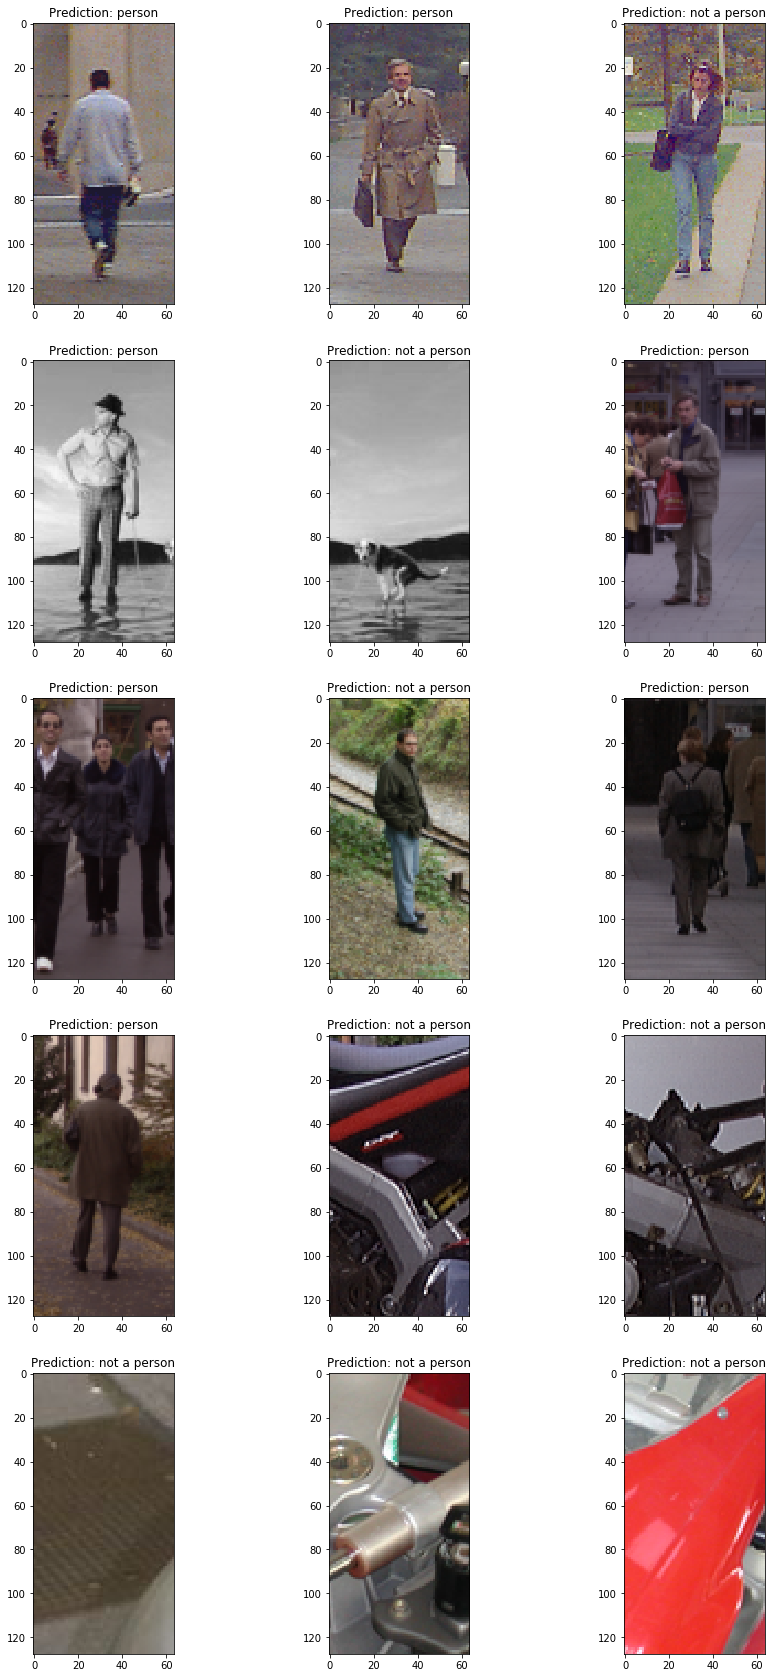

In [25]:
def visualize_predictions(images):
    predictions = clf.predict([hog_descriptor(x, use_g=True) for x in images])
    rows = int(np.ceil(len(images) // 3))
    
    fig, axes = plt.subplots(rows, 3, figsize=(15,30))
    axes = axes.reshape(-1)
    for i, ax in enumerate(axes):
        if i == len(images):
            break
        
        ax.imshow(images[i])
        ax.set_title("Prediction: " + ("person" if predictions[i] == 1 else "not a person"))

pos_from_data1 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/pos/person_097a.png'))
pos_from_data2 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/pos/person_224c.png'))
pos_from_data3 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/pos/person_327a.png'))
pos_from_data4 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/pos/person_044b.png'))
pos_from_data5 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/pos/person_233c.png'))
neg_from_data1 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/neg/no_person__no_bike_001.png'))
neg_from_data2 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/neg/no_person__no_bike_002.png'))
neg_from_data3 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/neg/no_person__no_bike_005.png'))
neg_from_data4 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/neg/no_person__no_bike_007.png'))
neg_from_data5 = crop_center(io.imread('./datasets/INRIAPerson/train_64x128_H96/neg/no_person__no_bike_008.png'))

visualize_predictions([pers1, pers2, pers3, unknown_1, unknown_2, 
                       pos_from_data1, pos_from_data2, pos_from_data3, pos_from_data4,
                       pos_from_data5, neg_from_data1, neg_from_data2, neg_from_data3, 
                       neg_from_data4, neg_from_data5])